### Predicting Titanic Survival 


In this project we will use the titanic survival dataset to  build a classification model to predoict whether a passenger survives the sinking of the Titanic, based on  attributes of each passenger in the dataset

### import libraries


In [6]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


### Titanic DataSet

In [7]:
titanic=sns.load_dataset('titanic')
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [8]:
#select relevant features and the target
titanic.count()

survived       891
pclass         891
sex            891
age            714
sibsp          891
parch          891
fare           891
embarked       889
class          891
who            891
adult_male     891
deck           203
embark_town    889
alive          891
alone          891
dtype: int64

#Features to drop
we can  see that deck have a lot of missing values so we'll drop it 
age has quite a few missing values as well. Although it could be, embarked and embark_town don't seem relevant so we'll drop them as well. It's unclear what alive refers to so we'll ignore it.
### target
survived is our target class variable.

In [9]:
features = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'class', 'who', 'adult_male', 'alone']
target = 'survived'

X = titanic[features]
y = titanic[target]
#checking how balanced are the classes
y.value_counts()

0    549
1    342
Name: survived, dtype: int64

So about 38% of the passengers in the data set survived.  
Because of this slight imbalance, we should stratify the data when performing train/test split and for cross-validation.

### Split data into Training and testing data

In [ ]:
X_train,X_test,y_test,y_test=train_test_split(X,y,test_size=0.2,random=42,stratify=y)

### Deefine separate preprocessig  pipelines fro both features types


In [20]:

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
numerical_features = X_train.select_dtypes(include=['number']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_transformer=Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


### Create  a model pipeline

In [26]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


### Define a parameter grid

In [22]:
param_grid={
    'classifier__n_estimators':[50,100],
    'classifier__max_depth':[None,10,20],
    'classifier__min_samples_split':[2,5]
}

### Perform Grid search cross-validation and fit the best mpde to the  training data

In [23]:
#cross validation method
cv= StratifiedKFold(n_splits=5,shuffle=True)

###  Train the pipeline model

In [31]:
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

model = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=0)
model.fit(X_train, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['pclass',
                                                                          'age',
                                                                          'sibsp',
                                                                          'parch',
                                                                          'fare']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['sex',
                                                                          'class',
                                                                          'who'])])),
                                       ('classifier',
                                        RandomForestClassifier())]),
             param_grid={'classifier__max_depth': [None, 10, 20],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [50, 100]},
             scoring='accuracy')

### Get the model predictions from the grid search estimatoor on the unseen data


In [32]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       110
           1       0.78      0.72      0.75        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.82      0.81       179



### Plot the confusion matrix

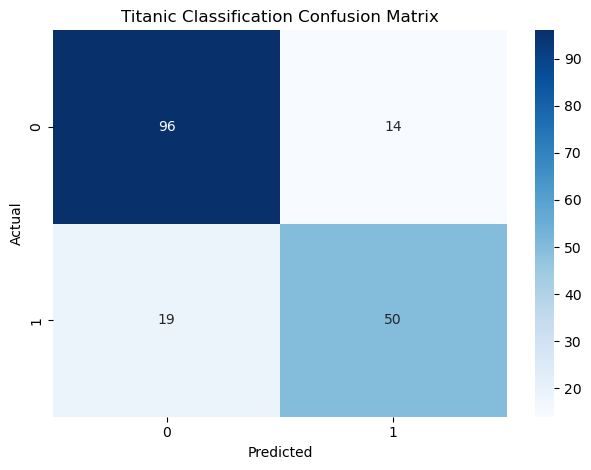

In [33]:
#generate the confusion matrix
conf_matrix=confusion_matrix# Generate the confusion matrix 
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')

# Set the title and labels
plt.title('Titanic Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.tight_layout()
plt.show()

### Feature importances


In [34]:
# trace back through the trained model to access the one-hot encoded feature names:
model.best_estimator_['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)

array(['sex_female', 'sex_male', 'class_First', 'class_Second',
       'class_Third', 'who_child', 'who_man', 'who_woman'], dtype=object)

In [35]:
#let's get all of the feature importances and associate them with their transformed feature names.
feature_importances = model.best_estimator_['classifier'].feature_importances_

# Combine the numerical and one-hot encoded categorical feature names
feature_names = numerical_features + list(model.best_estimator_['preprocessor']
                                        .named_transformers_['cat']
                                        .named_steps['onehot']
                                        .get_feature_names_out(categorical_features))

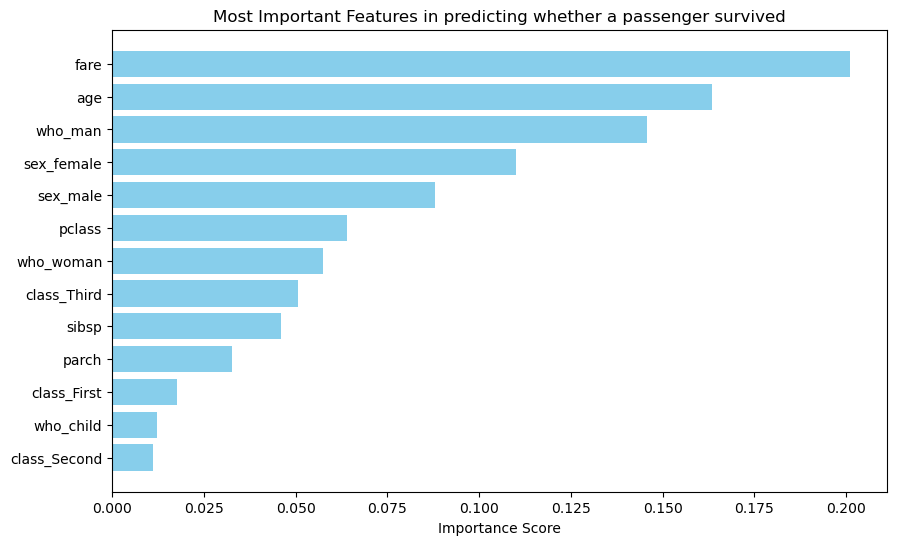


Test set accuracy: 81.56%


In [36]:
### Display feature importance on a bar plot
importance_df = pd.DataFrame({'Feature': feature_names,
                              'Importance': feature_importances
                             }).sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis() 
plt.title('Most Important Features in predicting whether a passenger survived')
plt.xlabel('Importance Score')
plt.show()

# Print test score 
test_score = model.score(X_test, y_test)
print(f"\nTest set accuracy: {test_score:.2%}")

The test set accuracy is somewhat satisfactory. However,regarding the feature impoirtances, it's crucially important to realize that there is most likely plenty of dependence amongst these variables, and a more detailed modelling approach including correlation analysis is required to draw proper conclusions. For example, no doubt there is significant information shared by the variables `age`, `sex_male`, and `who_man`.

### Display the clasification report for the new model and compare the results to your previous model.

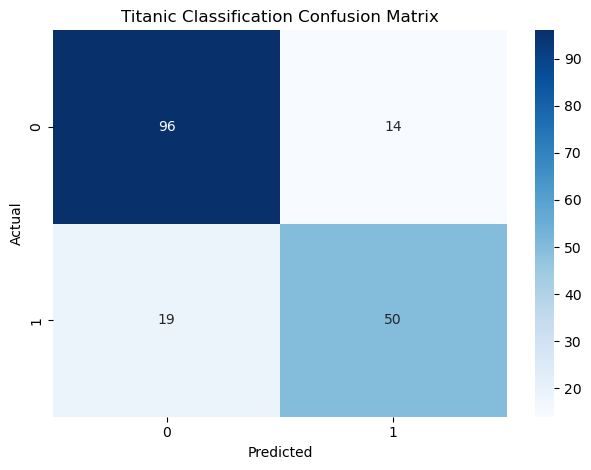

In [37]:
# Generate the confusion matrix 
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')

# Set the title and labels
plt.title('Titanic Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.tight_layout()
plt.show()

 ### Extract the logistic regression feature coefficients and plot their magnitude in a bar chart.

In [39]:
# Get feature importances
importances = model.best_estimator_.named_steps['classifier'].feature_importances_

# Get feature names
numerical_feature_names = numerical_features
categorical_feature_names = (
    model.best_estimator_.named_steps['preprocessor']
         .named_transformers_['cat']
         .named_steps['onehot']
         .get_feature_names_out(categorical_features)
)
feature_names = numerical_feature_names + list(categorical_feature_names)

# Combine into DataFrame
import pandas as pd
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display
print(feature_importances.head(10))


        Feature  Importance
4          fare    0.201086
1           age    0.163434
11      who_man    0.145755
5    sex_female    0.109947
6      sex_male    0.088050
0        pclass    0.064050
12    who_woman    0.057465
9   class_Third    0.050551
2         sibsp    0.046077
3         parch    0.032778


### Plot the feature coefficient magnitudes in a bar chart

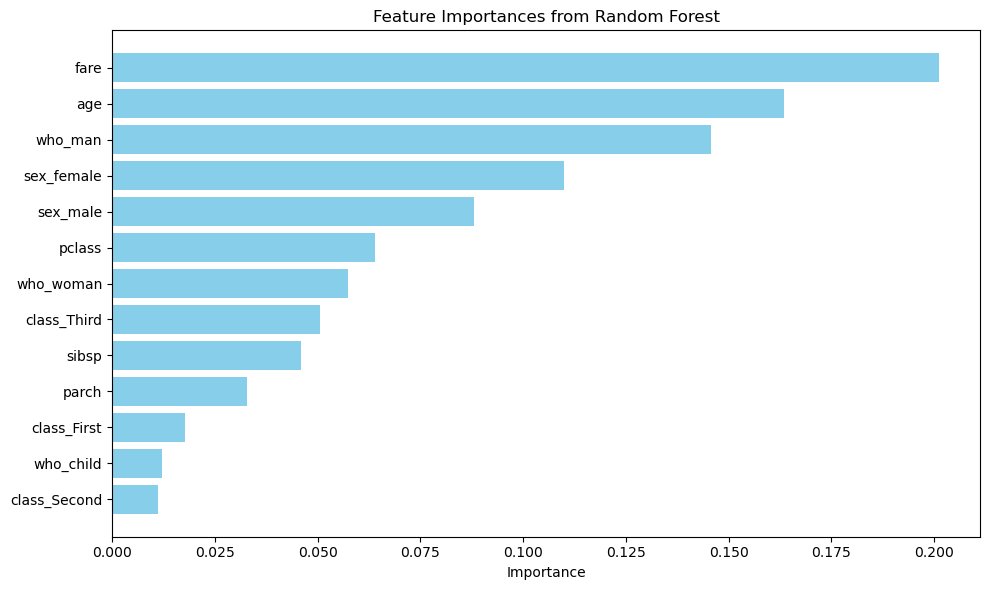


Test set accuracy: 81.56%


In [41]:
# Get feature importances
importances = model.best_estimator_.named_steps['classifier'].feature_importances_

# Get feature names
numerical_feature_names = numerical_features
categorical_feature_names = (
    model.best_estimator_.named_steps['preprocessor']
         .named_transformers_['cat']
         .named_steps['onehot']
         .get_feature_names_out(categorical_features)
)
feature_names = numerical_feature_names + list(categorical_feature_names)

# Create DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)  # ascending for horizontal bar plot

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# Print test score
test_score = model.best_estimator_.score(X_test, y_test)
print(f"\nTest set accuracy: {test_score:.2%}")

Although the performances of the two models are virtually identical, the features that are important to the two models are very different. This suggests there must be more work to do to better grasp the actual feature importancdes. A smentioned above, it's crucially important to realize that there is most likely plenty of dependence amongst these variables, and a more detailed modelling approach including correlation analysis is required to draw proper conclusions. For example, there is significant information implied between the variables who_man, who_woman, and who_child, because if a person is neither a man nor a woman, then they muct be a child.